In [1]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형모델 formula ( y ~ x1 + x2 + ...)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

# grhpviz
from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

# 앙상블 모델
from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import GridSearchCV


# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

# 폰트 설정
matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1) 데이터 구성

In [2]:
df_raw = pd.read_csv("./Data/Concrete.csv")

df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength", axis=1, inplace = False)

In [6]:
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# 데이터 스플릿
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.4, random_state=1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


In [7]:
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.951
Score on test set: 0.915


- 그냥 모델의 성느도 괜찮지만 테스트 데이터에 과적합된 부분이 있을 수도 있으므로 GridSearch를 통해최적의 파라미터를 찾아보도록 하겠다.

## 2) 최적의 파라미터 찾기

In [11]:
estimator = GBR()

# 리프 노드 수
para_leaf = [n_leaf * 1 for n_leaf in range(1, 10)]
# 스플릿 최소 자료 수
para_split = [n_leaf * 2 for n_leaf in range(2, 10)]
# 트리 깊이
para_depth = [depth for depth in range(1, 10)]
# # 학습률
# para_lr = [lr*0.1 for lr in range(1, 10)]
## 학습률은 별도로 파라미터 찾기 진행


# criterion은 mse만 비교
param_grid = {"criterion": ["mse"], 
              "max_depth": para_depth, "min_samples_split": para_split, 
              "min_samples_leaf": para_leaf, "learning_rate":[0.1]}

grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("best parmater: \n{}".format(grid_dt.best_params_))
print("nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
GradientBoostingRegressor(criterion='mse', max_depth=9, min_samples_leaf=9,
                          min_samples_split=8)
best parmater: 
{'criterion': 'mse', 'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 8}
nbest score: 
0.898


### n_estimator

In [12]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GBR(random_state=1234, n_estimators = v_n_estimators, min_samples_leaf = 9, 
             min_samples_split=8, max_depth=9)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["n_estimators"] = para_n_tree
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [13]:
# 모델 설명력 확인
df_score_leaf.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.801,0.766
1,20,0.936,0.889
2,30,0.966,0.914
3,40,0.976,0.921
4,50,0.981,0.925
5,60,0.983,0.927
6,70,0.985,0.928
7,80,0.987,0.930
8,90,0.988,0.931
9,100,0.989,0.932


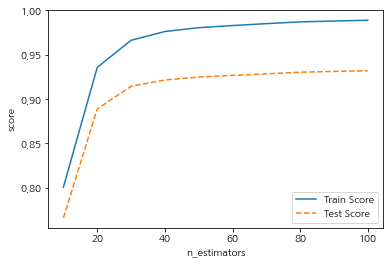

In [14]:
plt.plot(para_n_tree, train_score, linestyle="-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label = "Test Score")
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.legend()

※ estimator 40정도로 생각

### learning_rate

In [17]:
train_score = []; test_score = []

para_lr = [lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GBR(random_state=1234, n_estimators = 40, min_samples_leaf = 9, 
             min_samples_split=8, max_depth=9, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["LearningRate"] = para_lr
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [18]:
# 모델 설명력 확인
df_score_leaf.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.976,0.921
1,0.2,0.986,0.929
2,0.3,0.989,0.932
3,0.4,0.991,0.924
4,0.5,0.993,0.919
5,0.6,0.993,0.915
6,0.7,0.994,0.904
7,0.8,0.995,0.904
8,0.9,0.995,0.880


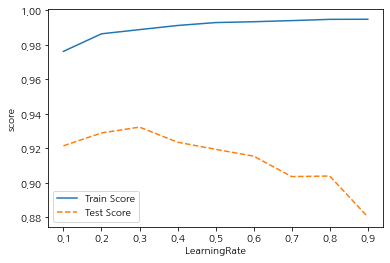

In [19]:
plt.plot(para_lr, train_score, linestyle="-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle="--", label = "Test Score")
plt.xlabel("LearningRate")
plt.ylabel("score")
plt.legend()

※ learning_rate는 0.3 정도

## 3) 결론 도출

In [29]:
# 최적모델

gb_final = GBR(random_state=1234, n_estimators = 40, min_samples_leaf = 9, 
             min_samples_split=8, max_depth=9, learning_rate=0.3)
gb_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.989
Score on test set: 0.932


- training스코어와 test스코어 모두 증가하는 모습을 보인다.

- 기본  
Score on training set: 0.951
Score on test set: 0.915

- 파라미터 변경  
Score on training set: 0.989
Score on test set: 0.932

- 트레이닝 셋이 어느정도 과적합이 됐지만, 테스트 셋의 점수도 같이 올랐기에 괜찮은 것으로 보인다.

### 평가함수

In [30]:
# 평가함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percenatage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) *  100

<BarContainer object of 4 artists>

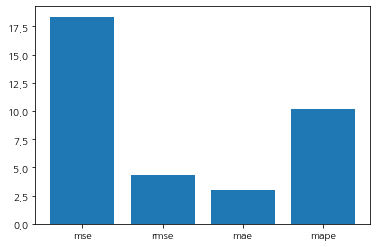

In [24]:
test = ["mse", "rmse", "mae", "mape"]
result = []

gb_pred = gb_final.predict(df_test_x)

result.append(mean_squared_error(df_test_y, gb_pred))
result.append(root_mean_squared_error(df_test_y, gb_pred))
result.append(mean_absolute_error(df_test_y, gb_pred))
result.append(mean_absolute_percenatage_error(df_test_y, gb_pred))

plt.bar(test, result)

- mse와 mae의 평가지표만으로 비교해보면 mae의 점수가 훨씬 낮게 나온다. 또한 rmse와 mape와 비교해봐도 mae가 가장 낮은 점수를 나타내기 때문에 mae의 성능이 훨씬 좋아보인다고 할 수 있다.

### 변수 중요도

In [32]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.332
0,cement,0.271
3,water,0.155
4,superplasticizer,0.078
1,blast_furnace_slag,0.056
6,fine_aggregate,0.055
5,coarse_aggregate,0.031
2,fly_ash,0.022


Text(0, 0.5, '변수(feature)')

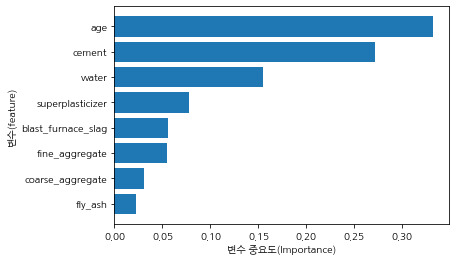

In [33]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도(Importance)")
plt.ylabel("변수(feature)")

- 변수 중요도는 age, cement, water 순으로 나타난다. 이전 다른 모델을 사용했을 때와 마찬가지로 주요 변수는 변하지 않은 듯 하다.